In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('hour_online.csv')

In [ ]:
df.tail()

,Time,Users
2620,4/20/17 5:00,34833
2621,4/20/17 6:00,35932
2622,4/20/17 7:00,38418
2623,4/20/17 8:00,40238
2624,4/20/17 9:00,40763


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Users,2625.0,40483.88419,14304.659157,0.0,29346.0,38314.0,48996.0,110716.0


In [ ]:
df[df['Users']==0]

,Time,Users
865,2/6/17 1:00,0
866,2/6/17 2:00,0
867,2/6/17 3:00,0
2256,4/5/17 1:00,0
2257,4/5/17 2:00,0
2258,4/5/17 3:00,0
2259,4/5/17 4:00,0
2260,4/5/17 5:00,0
2261,4/5/17 6:00,0


In [ ]:
df.isnull().sum()

,0
Time,0
Users,0


In [ ]:
data = df.copy()
data['Date'] = pd.to_datetime(df['Time'])
data = data.sort_values(by='Date')

data.head()

,Time,Users,Date
0,1/1/17 0:00,34002,2017-01-01 00:00:00
1,1/1/17 1:00,37947,2017-01-01 01:00:00
2,1/1/17 2:00,41517,2017-01-01 02:00:00
3,1/1/17 3:00,44476,2017-01-01 03:00:00
4,1/1/17 4:00,46234,2017-01-01 04:00:00


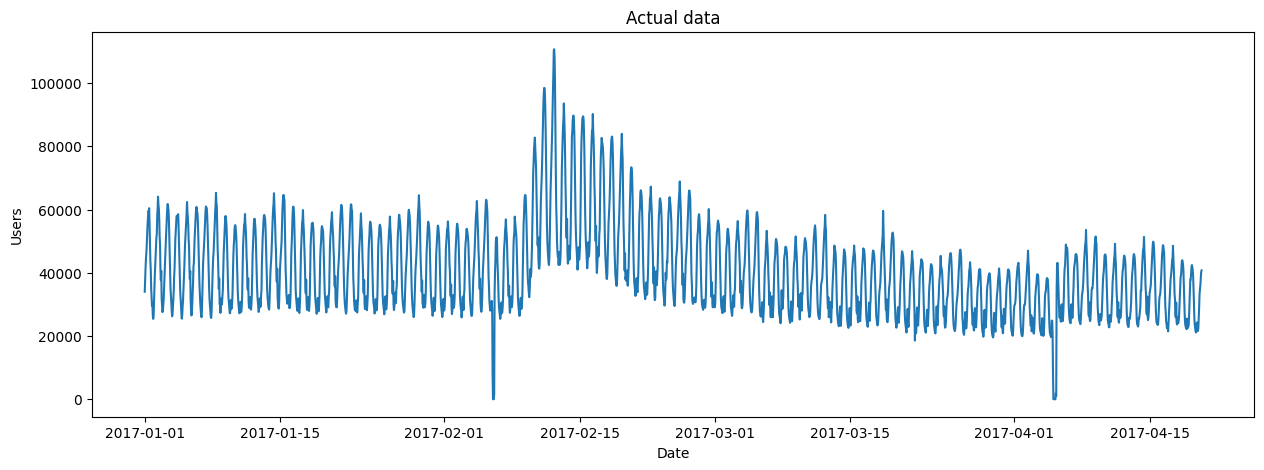

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'], data['Users'])
plt.xlabel('Date')
plt.ylabel('Users')
plt.title('Actual data')
plt.show()

# Тест Дики-Фуллера

## Проверка данных на стационарность

*   **Нулевая гипотеза (H₀)**: ряд нестационарен, т.е. содержит единичный корень.
*   **Альтернативная гипотеза (H₁)**: ряд стационарен., т.е. не содержит единичного корня.

In [ ]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(df.Users)
print('Критерий ADF: %f' % test[0])
print('P-значение: %f' % test[1])
print('Критические значения:')
for key, value in test[4].items():
  print('\t%s: %.3f' % (key, value))

if test[0] < test[4]["5%"]:
  print ("Нулевая гипотеза отвергается, ряд стационарен.")
else:
  print ("Нулевая гипотеза не отвергается, ряд не стационарен.")

Критерий ADF: -2.245379
P-значение: 0.190189
Критические значения:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Нулевая гипотеза не отвергается, ряд не стационарен.


# Модель ARIMA без преобразования данных

Модель ARIMA способна адаптировать ряд к стационарности «самостоятельно», за это свойство ответственен специальный параметр модели (d - дифференцирование).

## 1. Подбор гиперпараметров p, d, q для модели

*   **p (autoregressive lags)**: Количество прошлых значений временного ряда, которые используются для прогнозирования текущего значения.
*   **q (moving average lags)**: Количество ошибок прогноза прошлых периодов, которые учитываются при формировании нового прогноза.
*   **d (difference in the order)**: Число раз, которое необходимо продифференцировать данные, чтобы сделать их стационарными (т.е. устранить тренд и сезонность).

In [ ]:
!pip install optuna

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import itertools
import optuna

In [ ]:
train = data[data.Date<'2017-04-10 0:00'].Users
test = data[data.Date>='2017-04-10 0:00'].Users

p = q = range(1, 40)
d = range(1, 5)
pdq = list(itertools.product(p, d, q))


def objective_arima(trial):
    order = trial.suggest_categorical('order', pdq)
    model = ARIMA(train, order=order)
    mdl = model.fit()
    predictions = mdl.forecast(len(test))
    mae = mean_absolute_error(test, predictions)
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective_arima, n_trials=50)

Trial 5 finished with value: 2098.425042158273 and parameters: {'order': (26, 1, 32)}. Best is trial 5 with value: 2098.425042158273.

## 2. Кросс-валидация

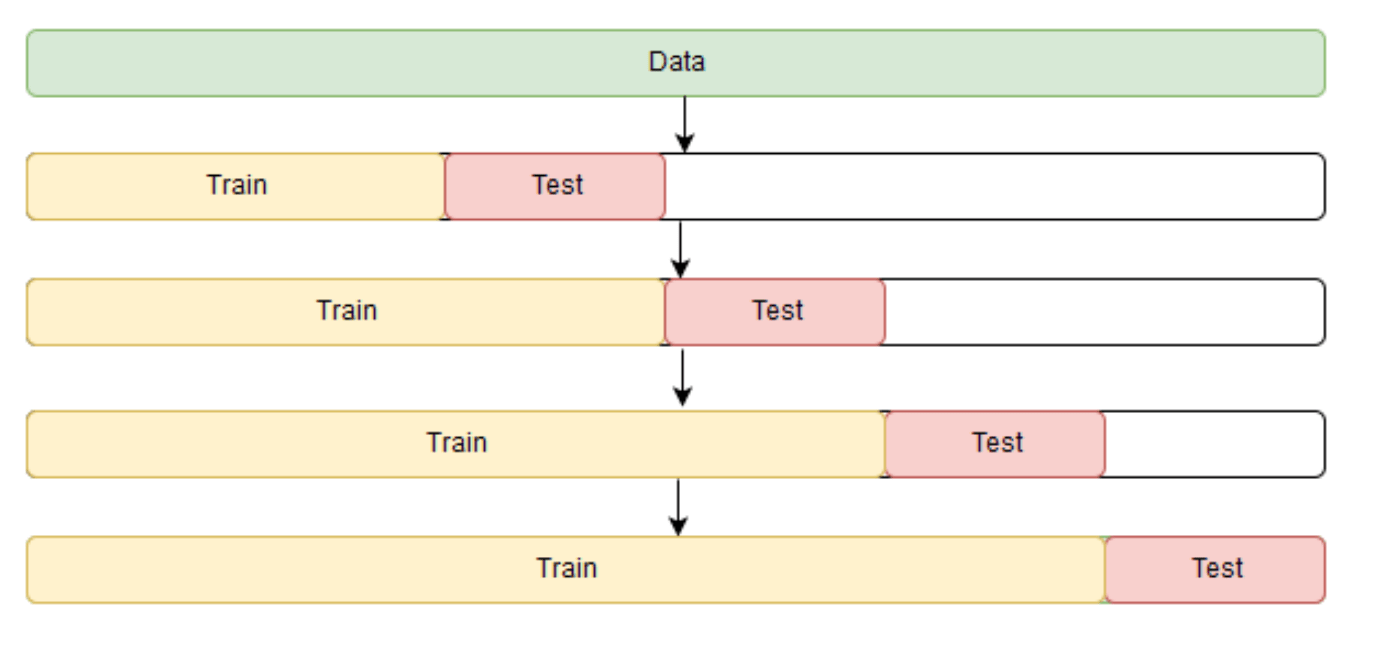

In [ ]:
data[data.Date>='2017-04-10 0:00'].count()    # 250 rows (test)

,0
Time,250
Users,250
Date,250


In [ ]:
length = -250

# cv3
train_3 = data.iloc[:length].Users
test_3 = data.iloc[length:].Users
# cv2
train_2 = train_3.iloc[:length]
test_2 = train_3.iloc[length:]
# cv1
train_1 = train_2.iloc[:length]
test_1 = train_2.iloc[length:]

In [ ]:
cv = pd.DataFrame(columns=['Test', 'MAE'])

In [ ]:
p, d, q = 26, 1, 32

# cv1
model = ARIMA(train_1, order=(p, d, q))
mdl = model.fit()
pred_1 = mdl.forecast(len(test_1))
error = mean_absolute_error(test_1, pred_1)
cv_test = {'Test': 'CV 1', 'MAE': error}
cv = pd.concat([cv, pd.DataFrame([cv_test])], ignore_index=True)

# cv2
model = ARIMA(train_2, order=(p, d, q))
mdl = model.fit()
pred_2 = mdl.forecast(len(test_2))
error = mean_absolute_error(test_2, pred_2)
cv_test = {'Test': 'CV 2', 'MAE': error}
cv = pd.concat([cv, pd.DataFrame([cv_test])], ignore_index=True)

# cv3
model = ARIMA(train_3, order=(p, d, q))
mdl = model.fit()
pred_3 = mdl.forecast(len(test_3))
error = mean_absolute_error(test_3, pred_3)
cv_test = {'Test': 'CV 3', 'MAE': error}
cv = pd.concat([cv, pd.DataFrame([cv_test])], ignore_index=True)

In [ ]:
cv.head()

,Test,MAE
0,CV 1,2415.580619
1,CV 2,5088.101281
2,CV 3,2098.425042


In [ ]:
print('MAE =', cv['MAE'].mean())

MAE = 3200.7023138811614


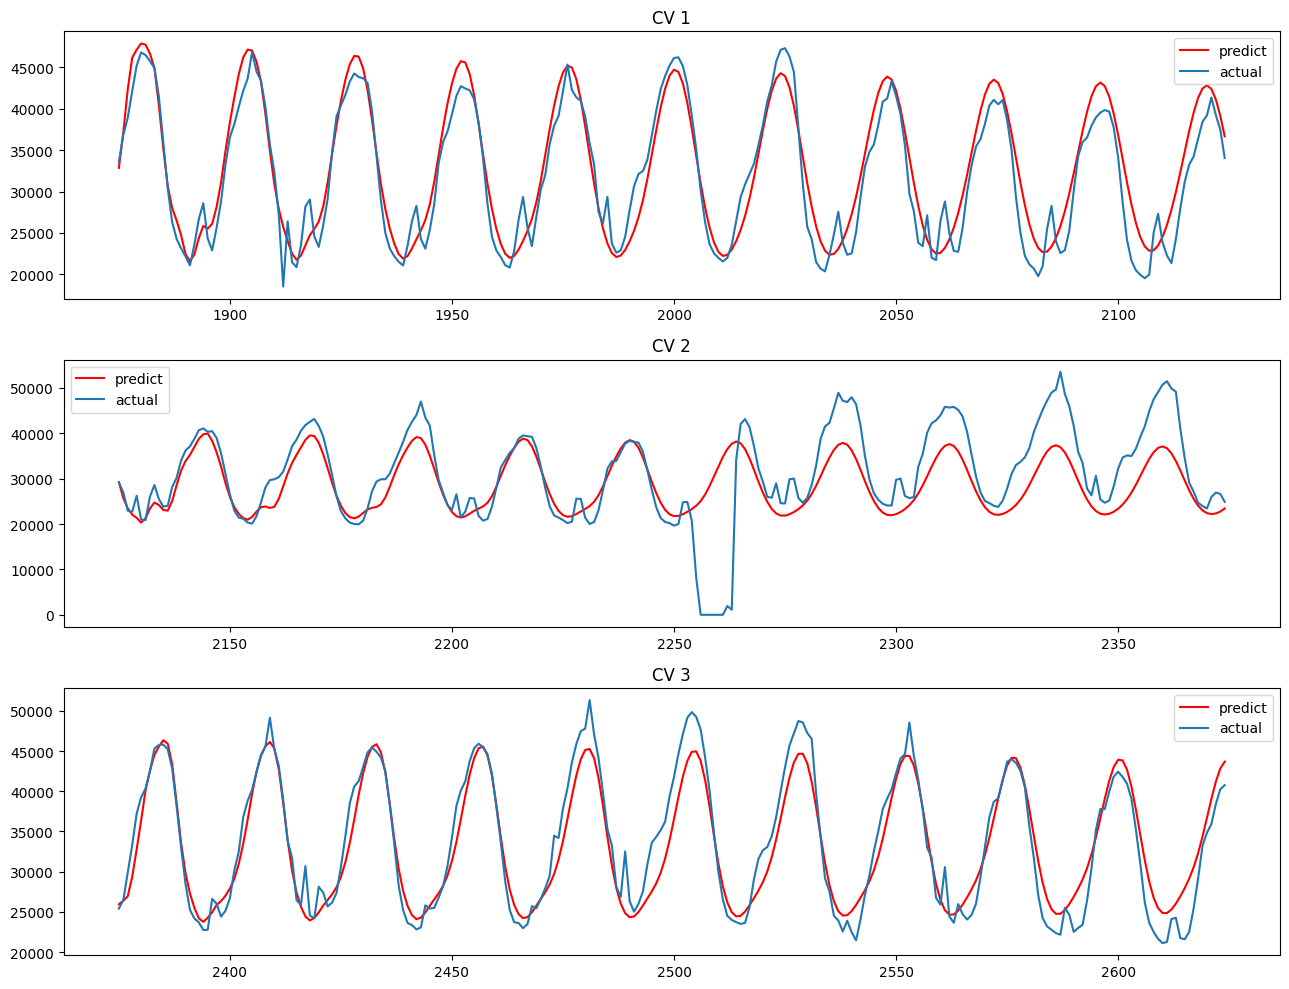

In [ ]:
plt.figure(figsize=(13,10))
plt.subplot(3,1,1)
plt.plot(pred_1, 'r', label = 'predict')
plt.plot(test_1, label = 'actual')
plt.title('CV 1')
plt.legend()

plt.subplot(3,1,2)
plt.plot(pred_2, 'r', label = 'predict')
plt.plot(test_2, label = 'actual')
plt.title('CV 2')
plt.legend()

plt.subplot(3,1,3)
plt.plot(pred_3, 'r', label = 'predict')
plt.plot(test_3, label = 'actual')
plt.title('CV 3')
plt.legend()
plt.tight_layout()
plt.show()

# Модель ARIMA с преобразованием данных

## 1. Преобразование нестационарных данных в стационарные

### Преобразование Бокса-Кокса

Преобразование Бокса-Кокса используется ***для стабилизации дисперсии*** временных рядов. Если дисперсия временного ряда изменяется со временем, это может нарушить предположения многих статистических методов, и преобразование Бокса-Кокса может помочь сделать дисперсию более постоянной.

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса

In [ ]:
data1 = data[['Users', 'Date']].copy()
data1['Users_box'], lmbda = boxcox(data1['Users']+1) # прибавляем единицу, тк в исходном ряде есть нули

print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)

test = adfuller(data1['Users_box'])
print('Тест Дики-Фуллера:')
print('Критерий ADF: %f' % test[0])
print('P-значение: %f' % test[1])
for key, value in test[4].items():
  print('\t%s: %.3f' % (key, value))

if test[0] < test[4]["5%"]:
  print ("Нулевая гипотеза отвергается, ряд стационарен.")
else:
  print ("Нулевая гипотеза не отвергается, ряд не стационарен.")

Оптимальный параметр преобразования Бокса-Кокса: 0.587270
Тест Дики-Фуллера:
Критерий ADF: -2.667900
P-значение: 0.079760
	1%: -3.433
	5%: -2.863
	10%: -2.567
Нулевая гипотеза не отвергается, ряд не стационарен.


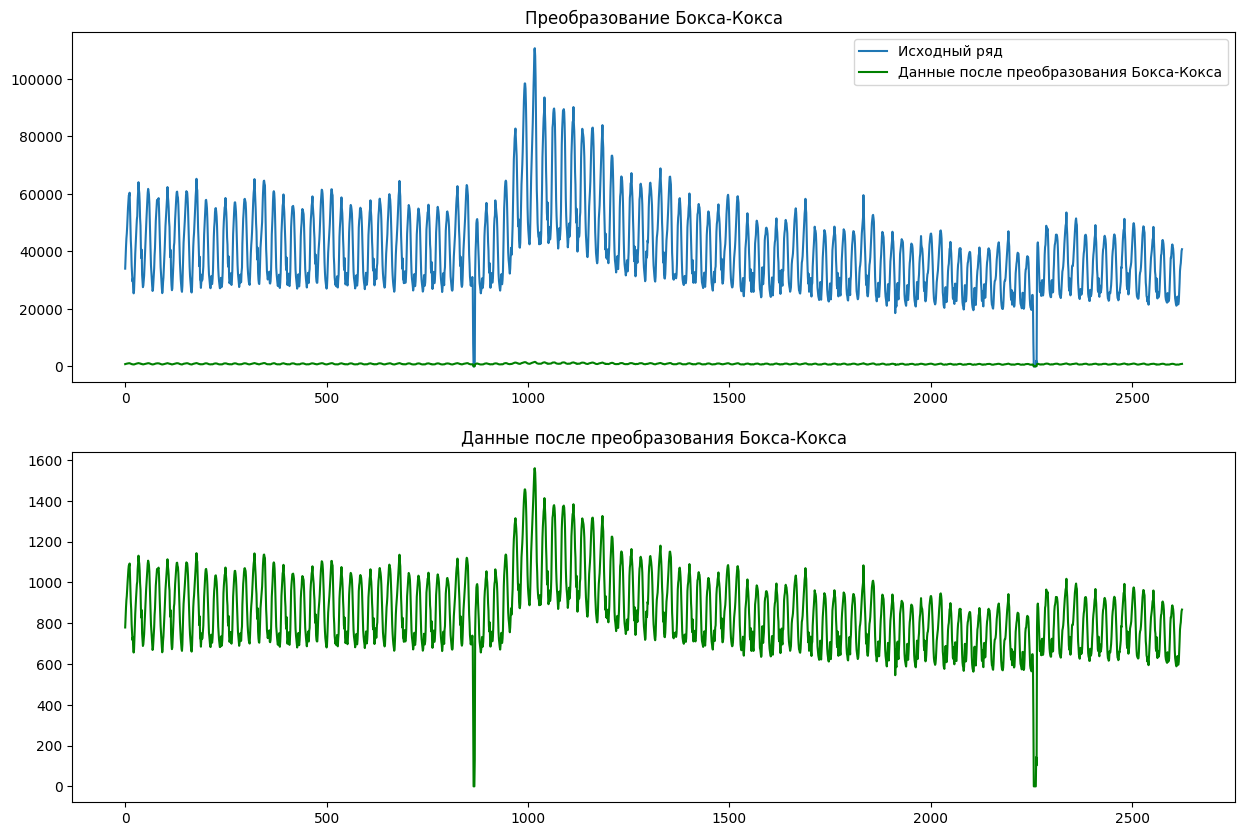

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(data1['Users'], label='Исходный ряд')
plt.plot(data1['Users_box'], label='Данные после преобразования Бокса-Кокса', color='green')
plt.title('Преобразование Бокса-Кокса')
plt.grid(False)
plt.legend()

plt.subplot(2,1,2)
plt.plot(data1['Users_box'], 'g')
plt.title('Данные после преобразования Бокса-Кокса')
plt.show()

### Дифференцирование

Дифференцирование - это простое преобразование ряда в новый временной ряд. Оно используется ***для устранения зависимости ряда от времени и стабилизации среднего значения*** ряда. В процессе дифференцирования тренд и сезонность уменьшаются.

In [ ]:
diff = data1['Users_box'].diff().dropna()

test = adfuller(diff)
print('Тест Дики-Фуллера:')
print('Критерий ADF: %f' % test[0])
print('P-значение: %f' % test[1])
for key, value in test[4].items():
  print('\t%s: %.3f' % (key, value))

if test[0] < test[4]["5%"]:
  print ("Нулевая гипотеза отвергается, ряд стационарен.")
else:
  print ("Нулевая гипотеза не отвергается, ряд не стационарен.")

Тест Дики-Фуллера:
Критерий ADF: -12.275200
P-значение: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567
Нулевая гипотеза отвергается, ряд стационарен.


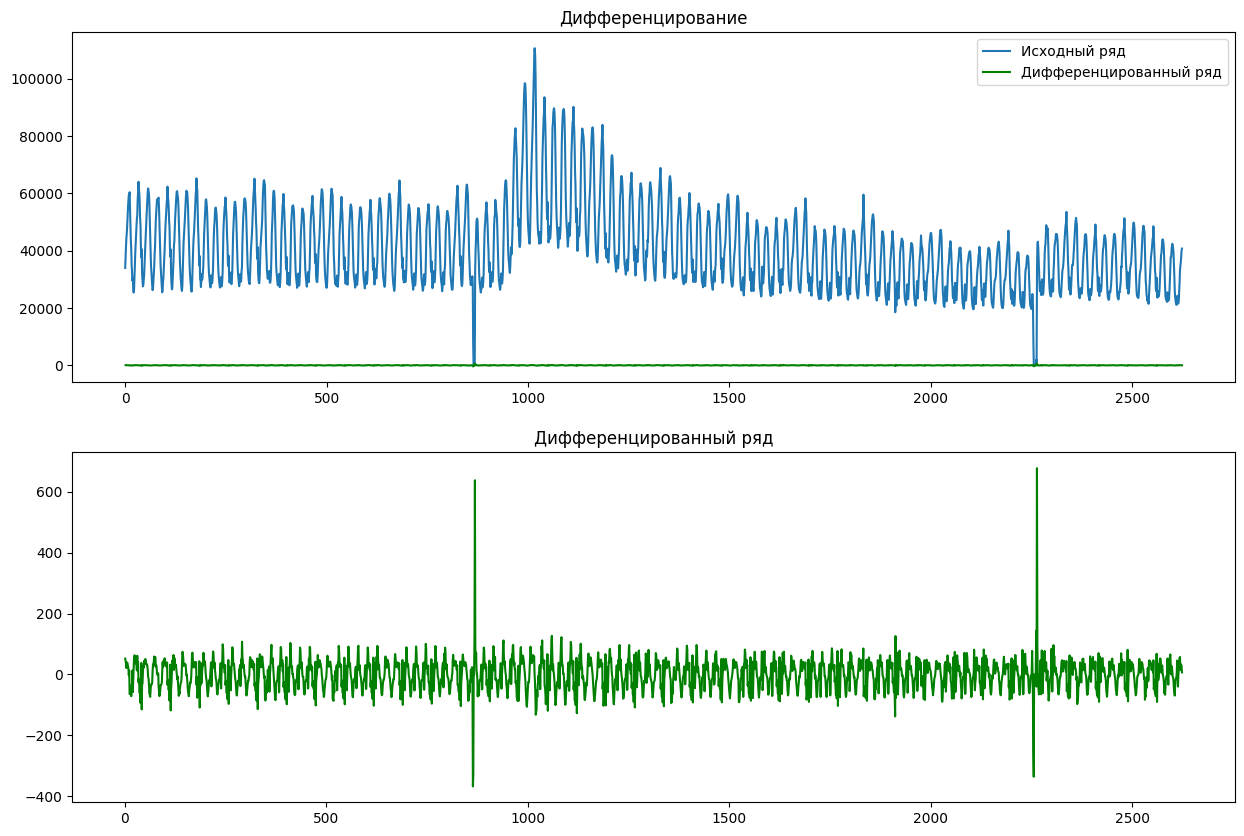

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(data1['Users'], label='Исходный ряд')
plt.plot(diff, label='Дифференцированный ряд', color='green')
plt.title('Дифференцирование')
plt.grid(False)
plt.legend()

plt.subplot(2,1,2)
plt.plot(diff, color='green')
plt.title('Дифференцированный ряд')
plt.grid(False)
plt.show()

## 2. Подбор гиперпараметров p, d, q для модели

In [ ]:
train = data1[data1.Date<'2017-04-10 0:00'].Users_box
test = data1[data1.Date>='2017-04-10 0:00'].Users_box

p = q = range(1, 40)
d = range(1, 5)
pdq = list(itertools.product(p, d, q))


def objective_arima(trial):
    order = trial.suggest_categorical('order', pdq)
    model = ARIMA(train, order=order)
    mdl = model.fit()
    predictions = inv_boxcox(mdl.forecast(len(test)), lmbda)
    test_users = data1['Users'][test.index]
    mae = mean_absolute_error(test_users, predictions)
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective_arima, n_trials=50)

Trial 1 finished with value: 2283.3238835466727 and parameters: {'order': (17, 1, 22)}. Best is trial 1 with value: 2283.3238835466727.

## 3. Кросс-валидация

In [ ]:
data1[data1.Date>='2017-04-10 0:00'].count()    # 250 rows (test)

,0
Users,250
Date,250
Users_box,250


In [ ]:
length = -250

# cv3
train_3_boxcox = data1.iloc[:length].Users_box
test_3_boxcox = data1.iloc[length:].Users_box
# cv2
train_2_boxcox = train_3_boxcox.iloc[:length]
test_2_boxcox = train_3_boxcox.iloc[length:]
# cv1
train_1_boxcox = train_2_boxcox.iloc[:length]
test_1_boxcox = train_2_boxcox.iloc[length:]

In [ ]:
cv_boxcox = pd.DataFrame(columns=['Test', 'MAE'])

In [ ]:
p, d, q = 17, 1, 22

# cv1
model = ARIMA(train_1_boxcox, order=(p, d, q))
mdl = model.fit()
pred_1_boxcox = inv_boxcox(mdl.forecast(len(test_1_boxcox)), lmbda)
error = mean_absolute_error(data1['Users'][test_1_boxcox.index], pred_1_boxcox)
cv_test = {'Test': 'CV 1', 'MAE': error}
cv_boxcox = pd.concat([cv_boxcox, pd.DataFrame([cv_test])], ignore_index=True)

# cv2
model = ARIMA(train_2_boxcox, order=(p, d, q))
mdl = model.fit()
pred_2_boxcox = inv_boxcox(mdl.forecast(len(test_2_boxcox)), lmbda)
error = mean_absolute_error(data1['Users'][test_2_boxcox.index], pred_2_boxcox)
cv_test = {'Test': 'CV 2', 'MAE': error}
cv_boxcox = pd.concat([cv_boxcox, pd.DataFrame([cv_test])], ignore_index=True)

# cv3
model = ARIMA(train_3_boxcox, order=(p, d, q))
mdl = model.fit()
pred_3_boxcox = inv_boxcox(mdl.forecast(len(test_3_boxcox)), lmbda)
error = mean_absolute_error(data1['Users'][test_3_boxcox.index], pred_3_boxcox)
cv_test = {'Test': 'CV 3', 'MAE': error}
cv_boxcox = pd.concat([cv_boxcox, pd.DataFrame([cv_test])], ignore_index=True)

In [ ]:
cv_boxcox.head()

,Test,MAE
0,CV 1,3320.471110
1,CV 2,4908.833351
2,CV 3,2283.323884


In [ ]:
print('MAE =', cv_boxcox['MAE'].mean())

MAE = 3504.2094481414183


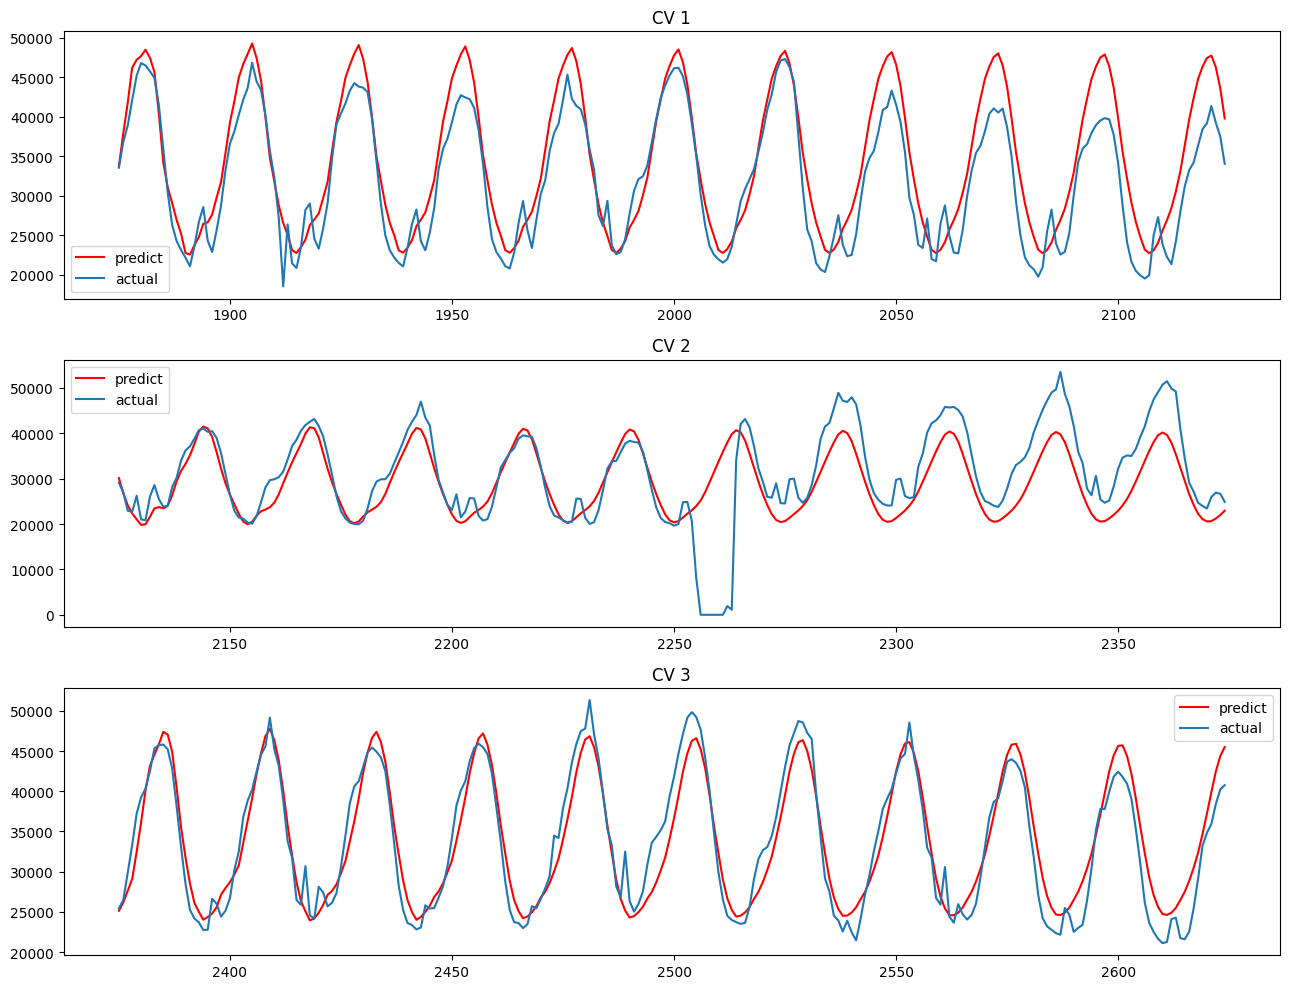

In [ ]:
plt.figure(figsize=(13,10))
plt.subplot(3,1,1)
plt.plot(pred_1_boxcox, 'r', label = 'predict')
plt.plot(data1['Users'][test_1_boxcox.index], label = 'actual')
plt.title('CV 1')
plt.legend()

plt.subplot(3,1,2)
plt.plot(pred_2_boxcox, 'r', label = 'predict')
plt.plot(data1['Users'][test_2_boxcox.index], label = 'actual')
plt.title('CV 2')
plt.legend()

plt.subplot(3,1,3)
plt.plot(pred_3_boxcox, 'r', label = 'predict')
plt.plot(data1['Users'][test_3_boxcox.index], label = 'actual')
plt.title('CV 3')
plt.legend()
plt.tight_layout()
plt.show()

# Результат MAE

In [ ]:
print('Результат MAE - модель ARIMA без преобразования данных')
cv.head()

Результат MAE - модель ARIMA без преобразования данных


,Test,MAE
0,CV 1,2415.580619
1,CV 2,5088.101281
2,CV 3,2098.425042


In [ ]:
print('Результат MAE - модель ARIMA с преобразованием данных (преобразование Бокса-Кокса)')
cv_boxcox.head()

Результат MAE - модель ARIMA с преобразованием данных (преобразование Бокса-Кокса)


,Test,MAE
0,CV 1,3320.471110
1,CV 2,4908.833351
2,CV 3,2283.323884


In [ ]:
print('MAE без преобразования данных =', cv['MAE'].mean())
print('MAE с преобразованием Бокса-Кокса =', cv_boxcox['MAE'].mean())

MAE без преобразования данных = 3200.7023138811614
MAE с преобразованием Бокса-Кокса = 3504.2094481414183


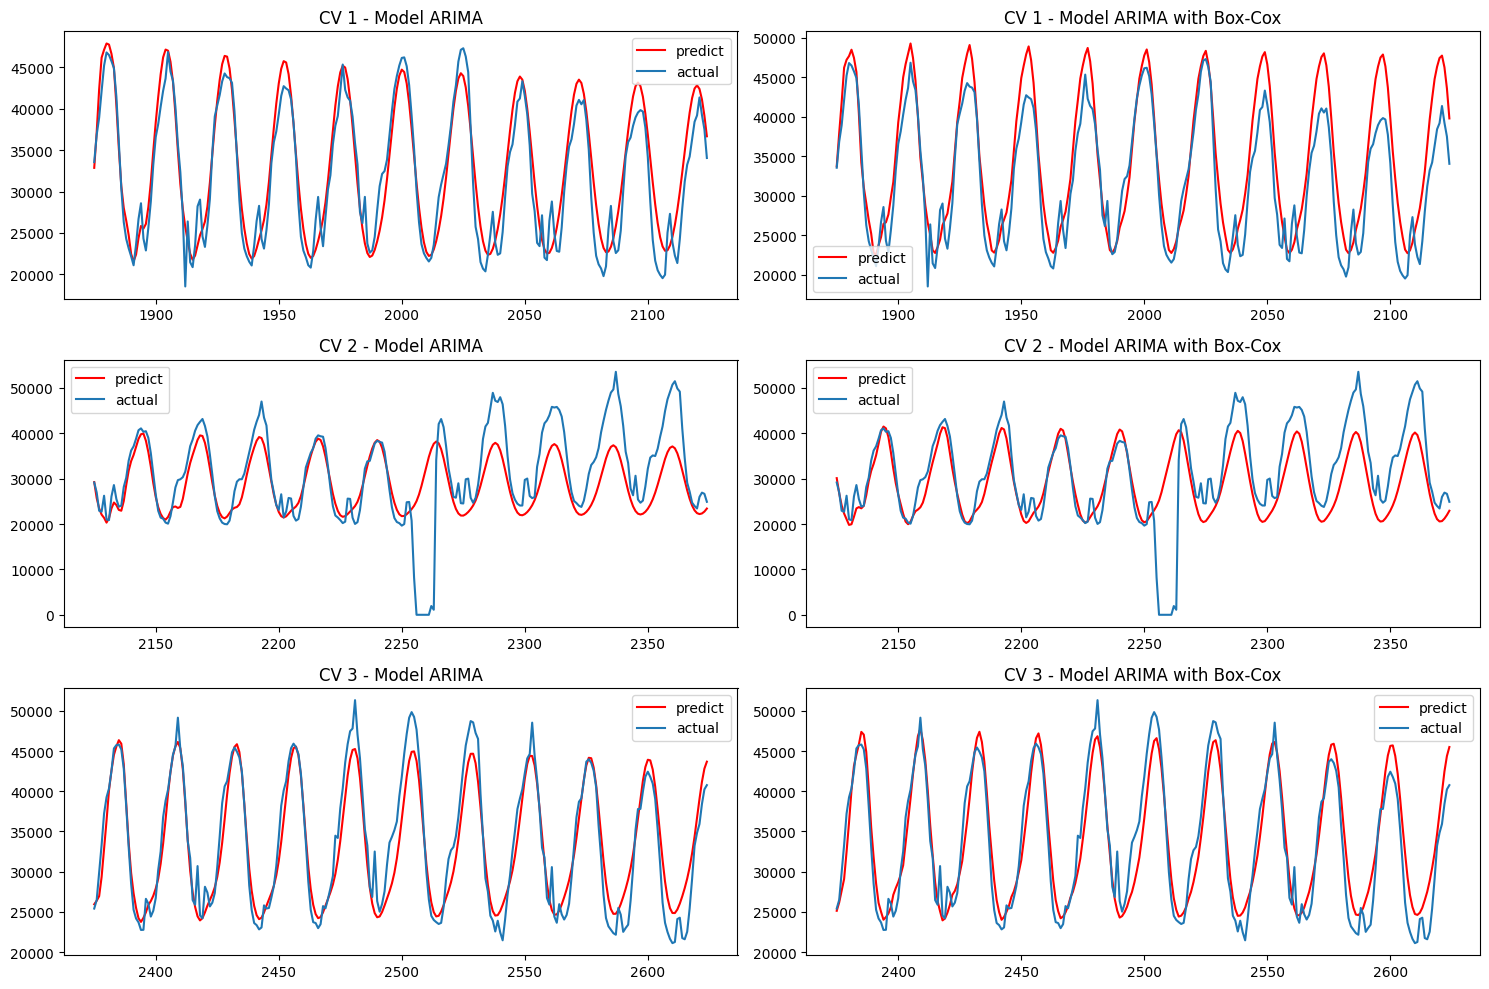

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
plt.plot(pred_1, 'r', label = 'predict')
plt.plot(test_1, label = 'actual')
plt.title('CV 1 - Model ARIMA')
plt.legend()

plt.subplot(3,2,2)
plt.plot(pred_1_boxcox, 'r', label = 'predict')
plt.plot(data1['Users'][test_1_boxcox.index], label = 'actual')
plt.title('CV 1 - Model ARIMA with Box-Cox')
plt.legend()

plt.subplot(3,2,3)
plt.plot(pred_2, 'r', label = 'predict')
plt.plot(test_2, label = 'actual')
plt.title('CV 2 - Model ARIMA')
plt.legend()

plt.subplot(3,2,4)
plt.plot(pred_2_boxcox, 'r', label = 'predict')
plt.plot(data1['Users'][test_2_boxcox.index], label = 'actual')
plt.title('CV 2 - Model ARIMA with Box-Cox')
plt.legend()

plt.subplot(3,2,5)
plt.plot(pred_3, 'r', label = 'predict')
plt.plot(test_3, label = 'actual')
plt.title('CV 3 - Model ARIMA')
plt.legend()

plt.subplot(3,2,6)
plt.plot(pred_3_boxcox, 'r', label = 'predict')
plt.plot(data1['Users'][test_3_boxcox.index], label = 'actual')
plt.title('CV 3 - Model ARIMA with Box-Cox')
plt.legend()
plt.tight_layout()
plt.show()